In [1]:
from src.printGraph import draw_graph as draw_graph
from src.Graph import Graph
import src.triangleAlgorithms as Ta

from test_ import HelperClass as Hc
import test_.plots.Performancetest_barplot as PerfTri
import test_.plots.TestsOnPowerNetworks as powerNetTest

import networkx as nx

import src.graphParameters as gP
import src.shortestPaths as sP
from src.Graph import Graph
import networkx as nx
import sys
import time
from collections import defaultdict
sys.setrecursionlimit(10000)

def Average(lst):
    return sum(lst) / len(lst)

## Cut-Knoten
Bei der Durchmesserberechnung muss die Breitensuche nicht von Cut-Knoten ausgeführt werden. Daher müssen zunächst alle Cut-Konten im Graph G gefunden werden. Hierzu verwenden wir den Tarjan’s Algorithmus:\
\
Zu diesem Zweck wird ein DFS-Tree erstellt und nach folgenden Bedingungen untersucht:\
u ist ein Cut-Knoten wenn einer der Bedingungen wahr ist:

u ist die Wurzel des Baumes und hat wenigstens 2 Kinder\
u ist nicht die Wurzel und hat ein Kind v in dessen Unterbaum es keinen Konten mit einer Back-Edge zu einem der Vorfahren im Baum von u gibt 

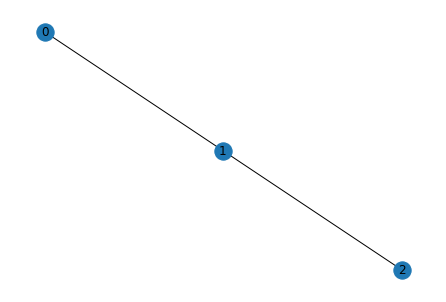

In [2]:
G = Graph()
G.add_edge(0,1)
G.add_edge(1,2)
draw_graph(G,label_on=True)

In [4]:
sP.find_cut_nodes(G)

{1}

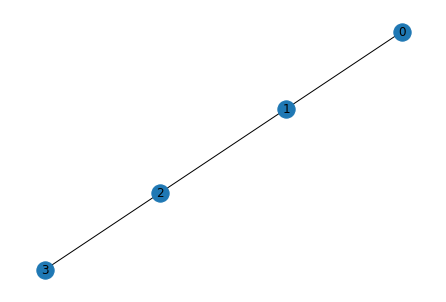

In [7]:
G.add_edge(2,3)
draw_graph(G,label_on=True)

In [8]:
sP.find_cut_nodes(G)

{1, 2}

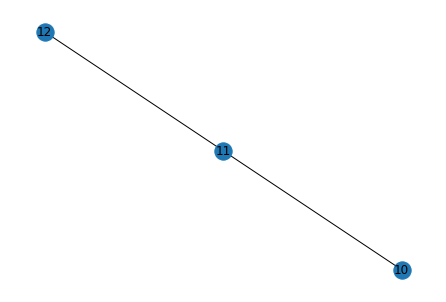

In [9]:
G = Graph()
G.add_edge(10,11)
G.add_edge(11,12)
draw_graph(G,label_on=True)

In [11]:
sP.find_cut_nodes(G)

{1}

![title](presentation/pictures/DFS-Algo.png)

Achtung: Die Funktion liefert interne Id's zurück

### Laufzeit:
O(|V|+|E|)

## Irrelevante Konten für den Diameter bei der All-Pair Shortest Path Methode

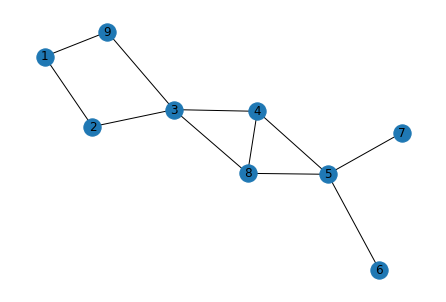

In [13]:
G = Graph()
G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,4)
G.add_edge(4,5)
G.add_edge(5,6)
G.add_edge(7,5)
G.add_edge(5,8)
G.add_edge(8,3)
G.add_edge(3,9)
G.add_edge(9,1)
G.add_edge(8,4)
draw_graph(G,label_on=True)

In [15]:
print("node_not_to_visit: ",sP.not_to_visit_neighbors_subset_nodes(G)[0]," same-distance: ",sP.not_to_visit_neighbors_subset_nodes(G)[1])

node_not_to_visit:  {1, 2, 4, 6}  same-distance:  {6: 5, 8: 1}


![title](presentation/pictures/node_not_to_visit_algo_1.png)

![title](presentation/pictures/node_not_to_visit_algo_2.png)

## Optimierung von All-Pair-Shortest-Path

![title](presentation/pictures/Estimation.png)

![title](presentation/pictures/All_Pair_Shortest_Path.png)

## Analyse der Größenordnung der Verbesserung

![title](presentation/pictures/AllPair_Shortest_Path.png)

## Berechnung des Durchmessers

![title](presentation/pictures/Diameter.png)

![title](presentation/pictures/SpeedUpDiameter(2).png)

In [2]:
def generate_gnp_graph(n, p, netx=False):
    newG = nx.gnp_random_graph(n, p)
    if netx:
        return newG
    return translate_Graph(newG)

def translate_Graph(newG):
    nodes = nx.nodes(newG)
    G = Graph()
    for node in nodes:
        G.add_node(node)
    edges = nx.edges(newG)
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    return G

In [3]:
meanings = defaultdict(str)
meanings["econ-psmigr1.mtx"]= "US inter-county migration 1965-1970"
meanings["econ-beause.mtx"]= "US econ. transact. 1972 - comm. x indust."
meanings["econ-beaflw.mtx"]= "US econ. transact. 1972 - indust. x indust."
meanings["econ-beacxc.mtx"]= "US econ. transact. 1972 - comm. x comm."
meanings["econ-mahindas.mtx"]= "Economic model of Victoria, Australia, 1880"
meanings["econ-orani678.mtx"]= "Economic model of Australia, 1968-69"
meanings["econ-wm1.mtx"]= "Region in world economic model (1/15)"
            
def get_min_avg_max_cc(G):
    x = [gP.local_clustering_coefficient(G, str(i)) for i in G.node_ids_internal_ids.keys()]
    return([round(min(x),3),round(sum(x)/len(x),3),round(max(x),3)])

funcs ={} 
funcs["density"] = lambda G: round(gP.density(G),5)
funcs["max_degree"] = lambda G: gP.max_degree(G)
funcs["components"] = lambda G: len(sP.connected_components(G))
#funcs["degeneracy"] = lambda G,name : gP.degeneracy(G)[0]
funcs["degeneracy"] = lambda G : gP.degeneracy_bucket(G)[0]
funcs["global_cc"] = lambda G : round(gP.global_clustering_coefficient(G),3)
funcs["h_index"] = lambda G : gP.h_index(G)
funcs["diameter"] = lambda G : sP.diameter_opt(G,2)
funcs["cc"] = lambda G : get_min_avg_max_cc(G)

def get_stats(G: Graph, name, type):
    stats = [name, type, G.n, G.m]
    times = [name, type, G.n, G.m]
    for k in funcs:
        tick =  time.time()
        stats.append(funcs[k](G))
        tack =  time.time()
        times.append(round(tack-tick,2))
    stats = stats + [meanings[name]]
    times = times + [meanings[name]]
    return stats, times

In [4]:
import os
import pandas as pd

graph_files = []
for file in os.listdir("networks/econ_networks"):
    graph_files.append(file)
rand_names = ["rand_"+str(i) for i in range(len(graph_files))]

columns = ["name","type","nodes","edges"]+list(funcs.keys())+["meaning"]
df = pd.DataFrame(columns=columns)
time_df = pd.DataFrame(columns=columns)
for file,rand_name in zip(graph_files,rand_names):
    path = "networks/econ_networks/"+file
    print(path)

    G = Graph(path)
    stats,times = get_stats(G, file, "natural")
    time_df.loc[len(time_df)] = times
    df.loc[len(df)] = stats

    rand_G = generate_gnp_graph(G.n, stats[columns.index("density")])
    stats,times = get_stats(rand_G, rand_name, "random")
    time_df.loc[len(time_df)] = times
    df.loc[len(df)] = stats


networks/econ_networks/econ-beacxc.mtx
networks/econ_networks/econ-beaflw.mtx
networks/econ_networks/econ-beause.mtx
networks/econ_networks/econ-mahindas.mtx
networks/econ_networks/econ-orani678.mtx
networks/econ_networks/econ-psmigr1.mtx
networks/econ_networks/econ-wm1.mtx



## Degeneracy

### Erste Version
* Python priority queue, priority: node degree
* Problem: Speicher N² da entfernen langsam -> kein entfernen von Queue bei Grad Update
#### Algorithmus
* alle Knoten mit Grad-priority zur Queue hinzufügen 

Bis alle Knoten abgearbeitet:
* min Element aus Queue holen (O(1))
* Nachbarn mit ihrem Grad-1 zur Queue hinzufügen O(log(n))
    (nichts doppelt bearbeitet, da Kopien immer "höhere" Prio haben) 
    
Speicher O(N²), Komplexität O(M+NlogN)

### Mit selbst-implementierter auf Problem zugeschnittener Bucket-Queue
* max_prio = maximaler degree
* buckets-dictionary: set für jeden möglichen Grad bis max_prio
* pointer der auf minimalen vorhandenen Grad zeigt (initial: max_prio) 

methods: PUT, GET, und MOVE_TO
* **PUT**: neues element wird mit Grad hinzugefügt. wenn Grad < aktueller pointer: pointer = degree _O(1)_
* **GET**: node wird aus bucket mit minimaler prio geholt, und gleichzeitig entfernt (set.pop()) _O(1)_, \
eventuell update pointer (theoretisch: O(n), praktisch: suche von aktuellem pointer bis max_prio)
* **MOVE_TO**: wenn Nachbarknoten entfernt wird, und Grad geupdated werden muss  _O(1)_ \
wenn pointer auf aktuellen bucket zeigt, dekrementiere \
entferne aus aktuellem bucket, füge zum niedrigeren hinzu 

Speicher O(N), Komplexität O(M+N), 21-mal schneller

# Network Analysis: Real Data
* economic networks: Migration, economic transactions, general economic modeling of different regions

In [5]:
df

,name,type,nodes,edges,density,max_degree,components,degeneracy,global_cc,h_index,diameter,cc,meaning
0,econ-beacxc.mtx,natural,493,42176,0.34776,490,1,118,0.540,173,3,"[0, 0.718, 1.0]",US econ. transact. 1972 - comm. x comm.
1,rand_0,random,493,41954,0.34593,204,1,147,0.346,174,2,"[0.331, 0.346, 0.358]",
2,econ-beaflw.mtx,natural,502,44900,0.35705,495,1,122,0.542,179,3,"[0.0, 0.709, 1.0]",US econ. transact. 1972 - indust. x indust.
3,rand_1,random,502,45059,0.35832,213,1,155,0.358,183,2,"[0.35, 0.358, 0.367]",
4,econ-beause.mtx,natural,507,39428,0.30738,501,1,106,0.479,157,3,"[0.0, 0.698, 0.957]",US econ. transact. 1972 - comm. x indust.
5,rand_2,random,507,39411,0.30725,187,1,133,0.307,160,2,"[0.296, 0.308, 0.318]",
6,econ-mahindas.mtx,natural,1258,7513,0.00950,206,1,40,0.037,54,8,"[0.0, 0.061, 1.0]","Economic model of Victoria, Australia, 1880"
7,rand_3,random,1258,7442,0.00941,25,1,8,0.010,19,5,"[0.0, 0.01, 0.111]",
8,econ-orani678.mtx,natural,2529,86768,0.02714,1544,1,192,0.261,210,5,"[0.0, 0.274, 0.837]","Economic model of Australia, 1968-69"
9,rand_4,random,2529,86685,0.02712,97,1,53,0.027,85,3,"[0.015, 0.027, 0.042]",


In [6]:
time_df

,name,type,nodes,edges,density,max_degree,components,degeneracy,global_cc,h_index,diameter,cc,meaning
0,econ-beacxc.mtx,natural,493,42176,0.0,0.0,0.00,0.03,0.84,0.0,1.38,0.85,US econ. transact. 1972 - comm. x comm.
1,rand_0,random,493,41954,0.0,0.0,0.00,0.03,0.59,0.0,1.42,0.56,
2,econ-beaflw.mtx,natural,502,44900,0.0,0.0,0.00,0.03,0.97,0.0,1.56,0.97,US econ. transact. 1972 - indust. x indust.
3,rand_1,random,502,45059,0.0,0.0,0.00,0.03,0.68,0.0,1.53,0.65,
4,econ-beause.mtx,natural,507,39428,0.0,0.0,0.00,0.02,0.77,0.0,1.34,0.77,US econ. transact. 1972 - comm. x indust.
5,rand_2,random,507,39411,0.0,0.0,0.00,0.02,0.48,0.0,1.31,0.48,
6,econ-mahindas.mtx,natural,1258,7513,0.0,0.0,0.00,0.01,0.02,0.0,1.71,0.02,"Economic model of Victoria, Australia, 1880"
7,rand_3,random,1258,7442,0.0,0.0,0.00,0.01,0.01,0.0,1.37,0.01,
8,econ-orani678.mtx,natural,2529,86768,0.0,0.0,0.01,0.06,1.96,0.0,21.08,1.84,"Economic model of Australia, 1968-69"
9,rand_4,random,2529,86685,0.0,0.0,0.00,0.06,0.57,0.0,11.45,0.57,


In [7]:
df["x"] = df["density"]*df["nodes"]
df = df.sort_values(by="density")
random_nw = df[df['type'] == "random"]
natural_nw = df[df['type'] == "natural"]

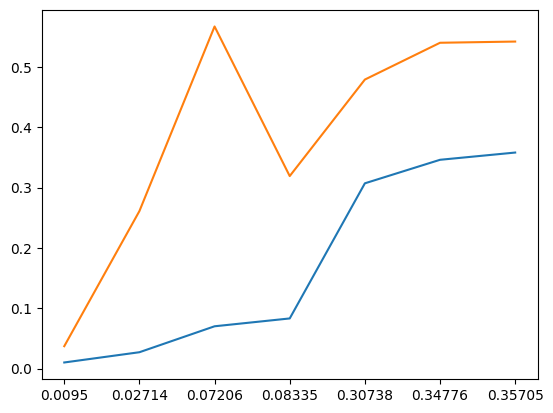

In [8]:
import matplotlib.pyplot as plt
plot_param = "global_cc"
num_nw = int(len(df)/2)
plt.xticks(ticks = range(num_nw),labels=natural_nw["density"])
plt.plot(range(num_nw), random_nw[plot_param])
plt.plot(range(num_nw), natural_nw[plot_param])

# triadic closure property of natural networks

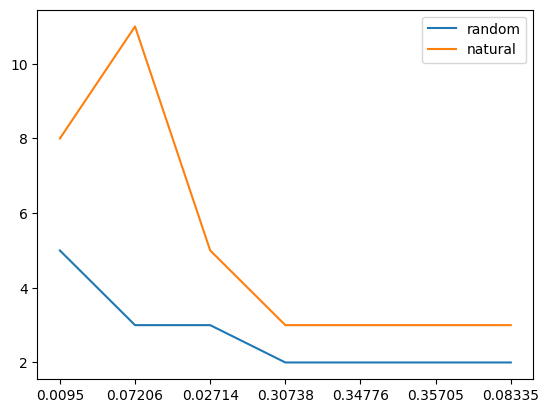

In [9]:
df = df.sort_values(by="x")
random_nw = df[df['type'] == "random"]
natural_nw = df[df['type'] == "natural"]

plot_param = "diameter"
num_nw = int(len(df)/2)
plt.xticks(ticks = range(num_nw),labels=natural_nw["density"])
plt.plot(range(num_nw), random_nw[plot_param],label="random")
plt.plot(range(num_nw), natural_nw[plot_param],label="natural")
plt.legend()

# tendenziell geringer bei random networks, da wegen power law wahrscheinlich viele schlecht verbundene knoten. 
# Ein schlecht verbundener Knoten ist schwer von einem anderen schlecht verbundenen KNoten zu erreichen

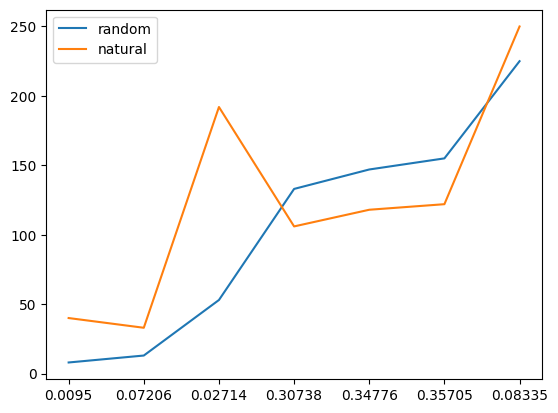

In [10]:
plot_param = "degeneracy"
num_nw = int(len(df)/2)

plt.xticks(ticks = range(num_nw),labels=natural_nw["density"])
plt.plot(range(num_nw), random_nw[plot_param],label="random")
plt.plot(range(num_nw), natural_nw[plot_param],label="natural")
plt.legend()

# je größer die Degeneracy, desto größer die gut verbundene "Core" des netzwerks
# Annahme: höher bei natürlichen Netzwerken (power law + triadic closure)
# outlier: transaction data US 72 

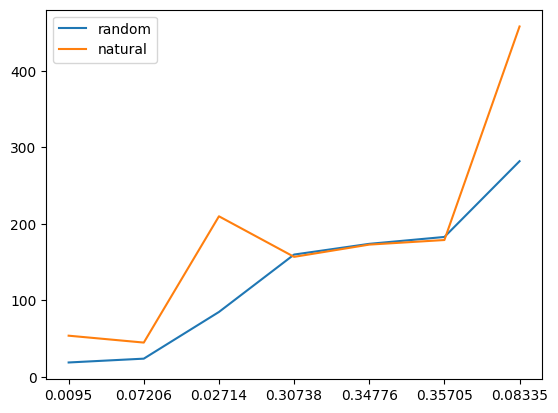

In [11]:
plot_param = "h_index"
num_nw = int(len(df)/2)
plt.xticks(ticks = range(num_nw),labels=natural_nw["density"])
plt.plot(range(num_nw), random_nw[plot_param],label="random")
plt.plot(range(num_nw), natural_nw[plot_param],label="natural")
plt.legend()

# relative anzahl gut verbundener Knoten. 
# Annahme: höher bei natürlichen Netzwerken durch heterogenität der Knoten-Grade

### Aufgabe 3 - Dreiecke

Algorithmen zum Aufzählen von Dreiecken. 
Hier haben wir uns an "Triangle Listing Algorithms: Back from the Diversion" von Mark Ortmann und Ulrik Brandes sowie "Algorithmic Aspects of Triangle-Based Network Analysis" von Thomas Schank orientiert.

Es wurden insgesamt 4 verschiedene Algorithmen implementiert. Zurückgegeben wird ein Tupel, wo der erste Wert die Anzahl an Dreiecken aus dem Graph zurückgibt. Der zweite Wert enthält die Aufzählung der Dreiecke als Liste von Tupeln.

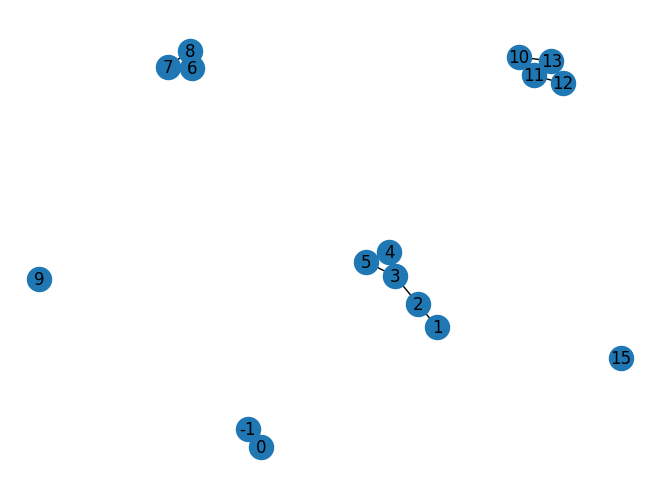

In [ ]:
G, _, _ = Hc.create_graph()
G.add_edge(11, 13)
G.add_edge(7, 8)

draw_graph(G, True)

Der erste Algorithmus ist im Prinzip ein trivialer Algorithmus, der die combinations Funktions aus dem iter Package nutzt. Im Prinzip werden für jeden Knoten alls Paare von Nachbarn betrachtet und nachgeschaut ob diese eine Verbindung haben

- Laufzeit: $O(\sum_{i=1} ^n deg(i)^2) = O(n\cdot deg_{max}^2 (G)) \subseteq O(n^3)$

In [ ]:
print(Ta.algorithm_with_combinations(G))

(4, [('3', '4', '5'), ('6', '7', '8'), ('10', '11', '13'), ('11', '12', '13')])


Der zweite Algorithmus ist der Node Iterator. Das heißt es wird über alle Knoten gegangen und jeweils alle Nachbarn betrachtet und dann geschaut ob diese Nachbarn sind. Hier wurden 3 verschiedene Ansätze implementiert: 

1) Ohne Sortierung - die Knoten wurden einfach der Reihe nach abgearbeitet  
    - Laufzeit: $O(n\cdot deg_{max}^2 (G))$
    - der einzige Unterschiede zu Algorithmus 1 ist, dass Knoten gelöscht werden 
2) Degenercy Sortierung - die Knoten wurden vom kleinsten Grad zum höchsten in die Degeneracy Ordnung gebracht
    - Laufzeit: $O(m + n\cdot log(n))$ + Ausführungszeit des Algorithmus
3) Knotengrad Sortierung -  Ein Dictionary wird erstellt mit keys Knotengrad und values Liste an Knoten die diesen Knotengrad besitzen
    - Laufzeit: $O(n)$ + Zugriffszeit auf das Dictionary und Ausführungszeit des Algorithmus

In [ ]:
print(Ta.algorithm_node_iterator_without_sorting(G))
print(Ta.algorithm_node_iterator_degeneracy_sorting(G))
print(Ta.algorithm_node_iterator_simple_sorting(G))

(4, [('3', '4', '5'), ('6', '7', '8'), ('10', '11', '13'), ('11', '12', '13')])
(4, [('3', '4', '5'), ('12', '11', '13'), ('13', '10', '11'), ('8', '7', '6')])
(4, [('3', '4', '5'), ('11', '10', '13'), ('11', '12', '13'), ('6', '7', '8')])


Der dritte Algorithmus ist der von Chiba und Nishizeki. Hier wird die einfache Sortierung von oben genutzt. Im Prinzip passiert aber das Gleiche wie beim node Iterator.

- Laufzeit: $O(m\cdot deg(G)) = O(m\cdot n)$

In [ ]:
print(Ta.algorithm_chiba_and_nishizeki(G))

(4, [('3', '4', '5'), ('11', '10', '13'), ('11', '12', '13'), ('6', '7', '8')])


Algorithmus 4 - ayz

Dieser Algorithmus ist nur in der Lage die Dreiecke zu zählen und kann sie nicht alle ausgeben
- Laufzeit: $O(m^{\frac{2\gamma}{\gamma + 1}})$

In [ ]:
print(Ta.algorithm_triangle_counter_ayz_internal_ids(G, 2))
print(Ta.algorithm_triangle_counter_ayz_internal_ids(G, 1))

(4, {0: 0, 1: 0, 2: 0, 3: 0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 0, 11: 1, 12: 2.0, 13: 1, 14: 2.0, 15: 0})
(4, {0: 0, 1: 0, 2: 0, 3: 0.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 0, 11: 1.0, 12: 2.0, 13: 1.0, 14: 2.0, 15: 0})


### Laufzeitvergleich

Nun vergleichen wir trotz Laufzeitbetrachtung nochmal alle aufgezählten Algorithmen miteinander und zusätzlich mit der Implementierung von NetworkX (nx.triangles)

networkX Implementierung

nodes_nbrs = G.adj.items()
for v, v_nbrs in nodes_nbrs:
    vs = set(v_nbrs) - {v}
    gen_degree = Counter(len(vs & (set(G[w]) - {w})) for w in vs)
    ntriangles = sum(k * val for k, val in gen_degree.items())
    yield (v, len(vs), ntriangles, gen_degree)

Im Prinzip werden die offenene Nachbarschaften von v und die offene Nachbarschaft eines Nachbarn von v (w) miteinander geschnitten. Hier bekommen wir allerdings keine Aufzählung der Dreiecke.

- Laufzeit: $O(n\cdot deg_{max}^2)$, aber dadurch, dass nur die Intersection gemacht wird, geht es schneller. Allerdings bekommen wir hier keine Aufzählung der Dreiecke.

In [ ]:
# Implementierung von NetworkX

# Umwandlung des Graphens in NetworkX Graph
nxG = nx.Graph()
for node in G.node_ids_internal_ids:
    nxG.add_node(node)
for key in G.edges:
    for n in G.edges[key]:
        nxG.add_edge(G.internal_ids_node_ids[key], G.internal_ids_node_ids[n])
print(nx.triangles(nxG))

{'-1': 0, '0': 0, '1': 0, '2': 0, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 0, '10': 1, '11': 2, '12': 1, '13': 2, '15': 0}


In [ ]:
# Vergleiche alle Algorithmen auf Graphen der Größe 100, 250, 500
# Initialisierung aller Werte
n_array = [100, 250, 500]
functions = [Ta.algorithm_with_combinations,
             Ta.algorithm_node_iterator_without_sorting, Ta.algorithm_node_iterator_simple_sorting, Ta.algorithm_node_iterator_degeneracy_sorting,
             Ta.algorithm_chiba_and_nishizeki,
             nx.triangles]
names = ["using Combinations",
         "Node iterator, no sorting", "Node iterator, simple sorting", "Node iterator, deg sorting",
         "chiba and nis",
         "networkX"]
colors = ["gray",
          "lightcoral", "brown", "darkred",
          "teal",
          "blue"]

100
0
1
2
3
250
0
1
2
3
500
0
1
2
3


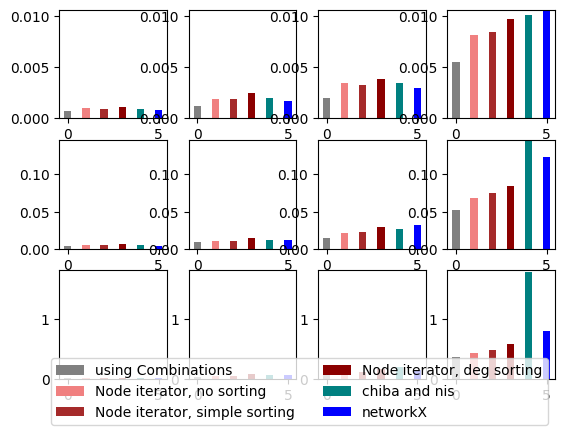

In [ ]:
# Was sind die Dichten der Kanten
p_array = [[0.01, 0.05, 0.1, 0.25] for entry in n_array]
# run and plot algorithms for k Iterations
k = 20
PerfTri.test_and_plot_results(n_array, p_array, functions, names, k, colors=colors, netx=[5], useGnp=True)

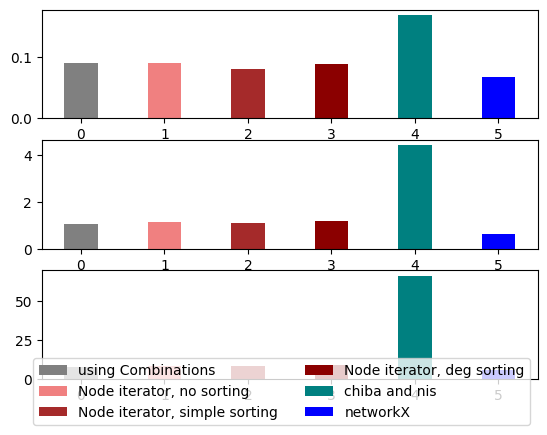

In [ ]:
# test die Algorithmen für fully-connected Graphs
PerfTri.test_and_plot_fully_connected(n_array, functions, names, 1, colors, netx=[5])

Starting function Node iterator, no sorting
Starting function Node iterator, simple sorting
Starting function Node iterator, deg sorting
Starting function networkX


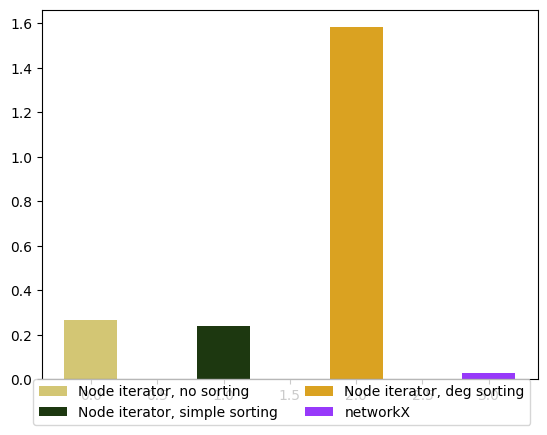

In [ ]:
# Teste das Ganze für die Power Networks

functions = [Ta.algorithm_node_iterator_without_sorting, 
             Ta.algorithm_node_iterator_simple_sorting,
             Ta.algorithm_node_iterator_degeneracy_sorting,
             nx.triangles]
names = ["Node iterator, no sorting",
         "Node iterator, simple sorting",
         "Node iterator, deg sorting",
         "networkX"]
colors = ["gray",
          "red",
          "teal",
          "blue"]

normalTests = powerNetTest.TestTriangleImplementationPowerNetworks(functions, names, 
                                                                   "networks/power_networks/", [3])
normalTests.plot_and_run()

Starting gamma 0
Starting gamma 1
Starting gamma 2
Starting gamma 3
Starting gamma 4
Starting gamma 5
Starting gamma 10


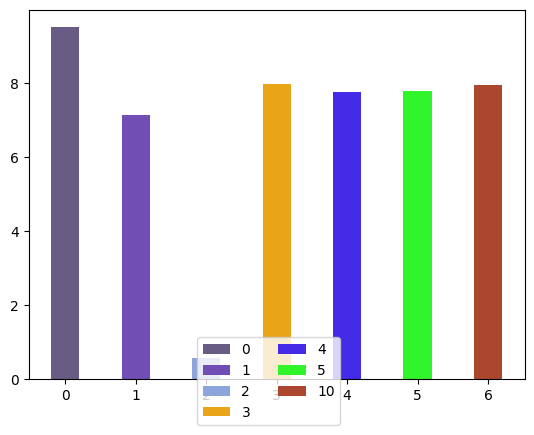

In [ ]:
# Teste den ayz Algorithmus für verschiedene gamma
ayzTests = powerNetTest.TestAYZImplementationOnPowerNetworks([0, 1, 2, 3, 4, 5, 10], 
                                                             "networks/power_networks/")
ayzTests.plot_and_run()

750
0
1
1000
0
1


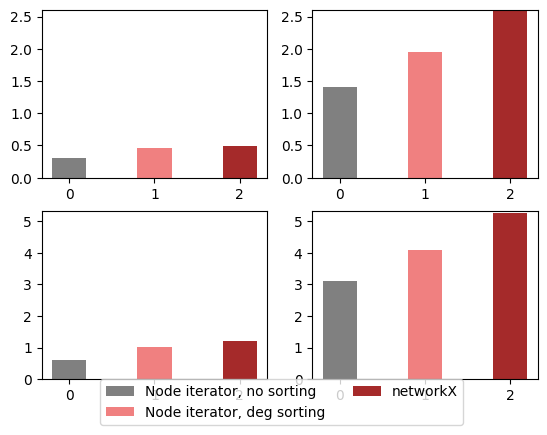

In [ ]:
# Degeneracy Sorting vs no sorting vs networkx in large Graph
n_array2 = [750, 1000]
k2 = 10
functions2 = [Ta.algorithm_node_iterator_without_sorting, 
             Ta.algorithm_node_iterator_degeneracy_sorting,
             nx.triangles]
names2 = ["Node iterator, no sorting", 
         "Node iterator, deg sorting",
         "networkX"]
colors2 = ["gray",
          "lightcoral", 
          "brown"]

# Was sind die Dichten der Kanten
p_array2 = [[0.1, 0.25] for entry in n_array2]
PerfTri.test_and_plot_results(n_array2, p_array2, functions2, names2, k2, colors=colors2, netx=[2], useGnp=True)